In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math 
from tqdm import tqdm
import seaborn as sns
import os
import re
import datetime
base_folder = '/content/drive/MyDrive/Data project (VITA)/'
calibration_datafoler = base_folder+'codes/Calibrations 23.12.21'

## Camera Records data (labels)

In [17]:
records = pd.read_csv(base_folder+'Data/records.csv')
records

,user_id,class,sample_nb,start_time,end_time,date_time,right_hand,sitting
0,0,eye_rubbing,1,1.635610e+09,1.635610e+09,Sat Oct 30 18:10:07 2021,NaN,NaN
1,0,eye_rubbing,2,1.635610e+09,1.635610e+09,Sat Oct 30 18:10:16 2021,NaN,NaN
2,0,eye_rubbing,1,1.635612e+09,1.635612e+09,Sat Oct 30 18:44:08 2021,NaN,NaN
3,0,eye_rubbing,2,1.635612e+09,1.635612e+09,Sat Oct 30 18:44:16 2021,NaN,NaN
4,0,eye_rubbing,0,1.635613e+09,1.635613e+09,Sat Oct 30 18:56:49 2021,NaN,NaN
...,...,...,...,...,...,...,...,...
4741,39,Teeth brushing,5,1.639830e+09,1.639830e+09,Sat Dec 18 13:14:17 2021,1.0,1.0
4742,39,Make up removal,2,1.639830e+09,1.639830e+09,Sat Dec 18 13:14:28 2021,1.0,1.0
4743,39,Make up removal,3,1.639830e+09,1.639830e+09,Sat Dec 18 13:14:38 2021,1.0,1.0
4744,39,Eye rubbing light,1,1.639830e+09,1.639830e+09,Sat Dec 18 13:14:44 2021,1.0,1.0


## Apple watch data

### Read seperate data files for each user

In [ ]:
data_folder = base_folder + 'Data/Apple_Watch/'
# Get unique user ids from the data folder
unique_user_ids = []
for i, filename in enumerate(os.listdir(data_folder)):
  if filename[:4] == 'user':
    unique_user_ids.append(filename[:6])

In [ ]:
# Save all user's relative datas in one dictionary 
datas = {"user_id":[],"data":[],"calibration_data":[], "calibration_cam":[], "time_shift":[], "records_data":[]};
for user_id in tqdm(unique_user_ids):
  # Get watch data
  data = pd.read_csv(base_folder+'Data/Apple_Watch/{}.csv'.format(user_id), sep=';')
  data.rename(columns = {'loggingTime(txt)':'epoc (ms)'}, inplace = True)
  data['epoc (ms)'] = pd.to_datetime(data['epoc (ms)']).apply(lambda x: x.timestamp())
  # Get calibraiton data from camera
  path_to_calibration = '/content/drive/MyDrive/Data project (VITA)/codes/Calibrations 23.12.21'+'/calibration{}.csv'.format(user_id[4:])
  if int(user_id[4:])>=27: # After debugging, the naming of the apple watch data turned out shifted by 1, starting from user 27
    path_to_calibration = '/content/drive/MyDrive/Data project (VITA)/codes/Calibrations 23.12.21'+'/calibration{}.csv'.format(str(int(user_id[4:])+1))
  calibration_cam = pd.read_csv(path_to_calibration)
  calibration_cam['time'] = calibration_cam['time']
  # Get calibration data from watch
  calibration_data = data[calibration_cam['time'][0]<data['epoc (ms)']][data['epoc (ms)'] <= np.array(calibration_cam['time'])[-1]]
  # Append everything to dictionary
  datas["user_id"].append(user_id)
  datas["data"].append(data)
  datas["calibration_data"].append(calibration_data)
  datas["calibration_cam"].append(calibration_cam)

### Features visualization and basic statistics

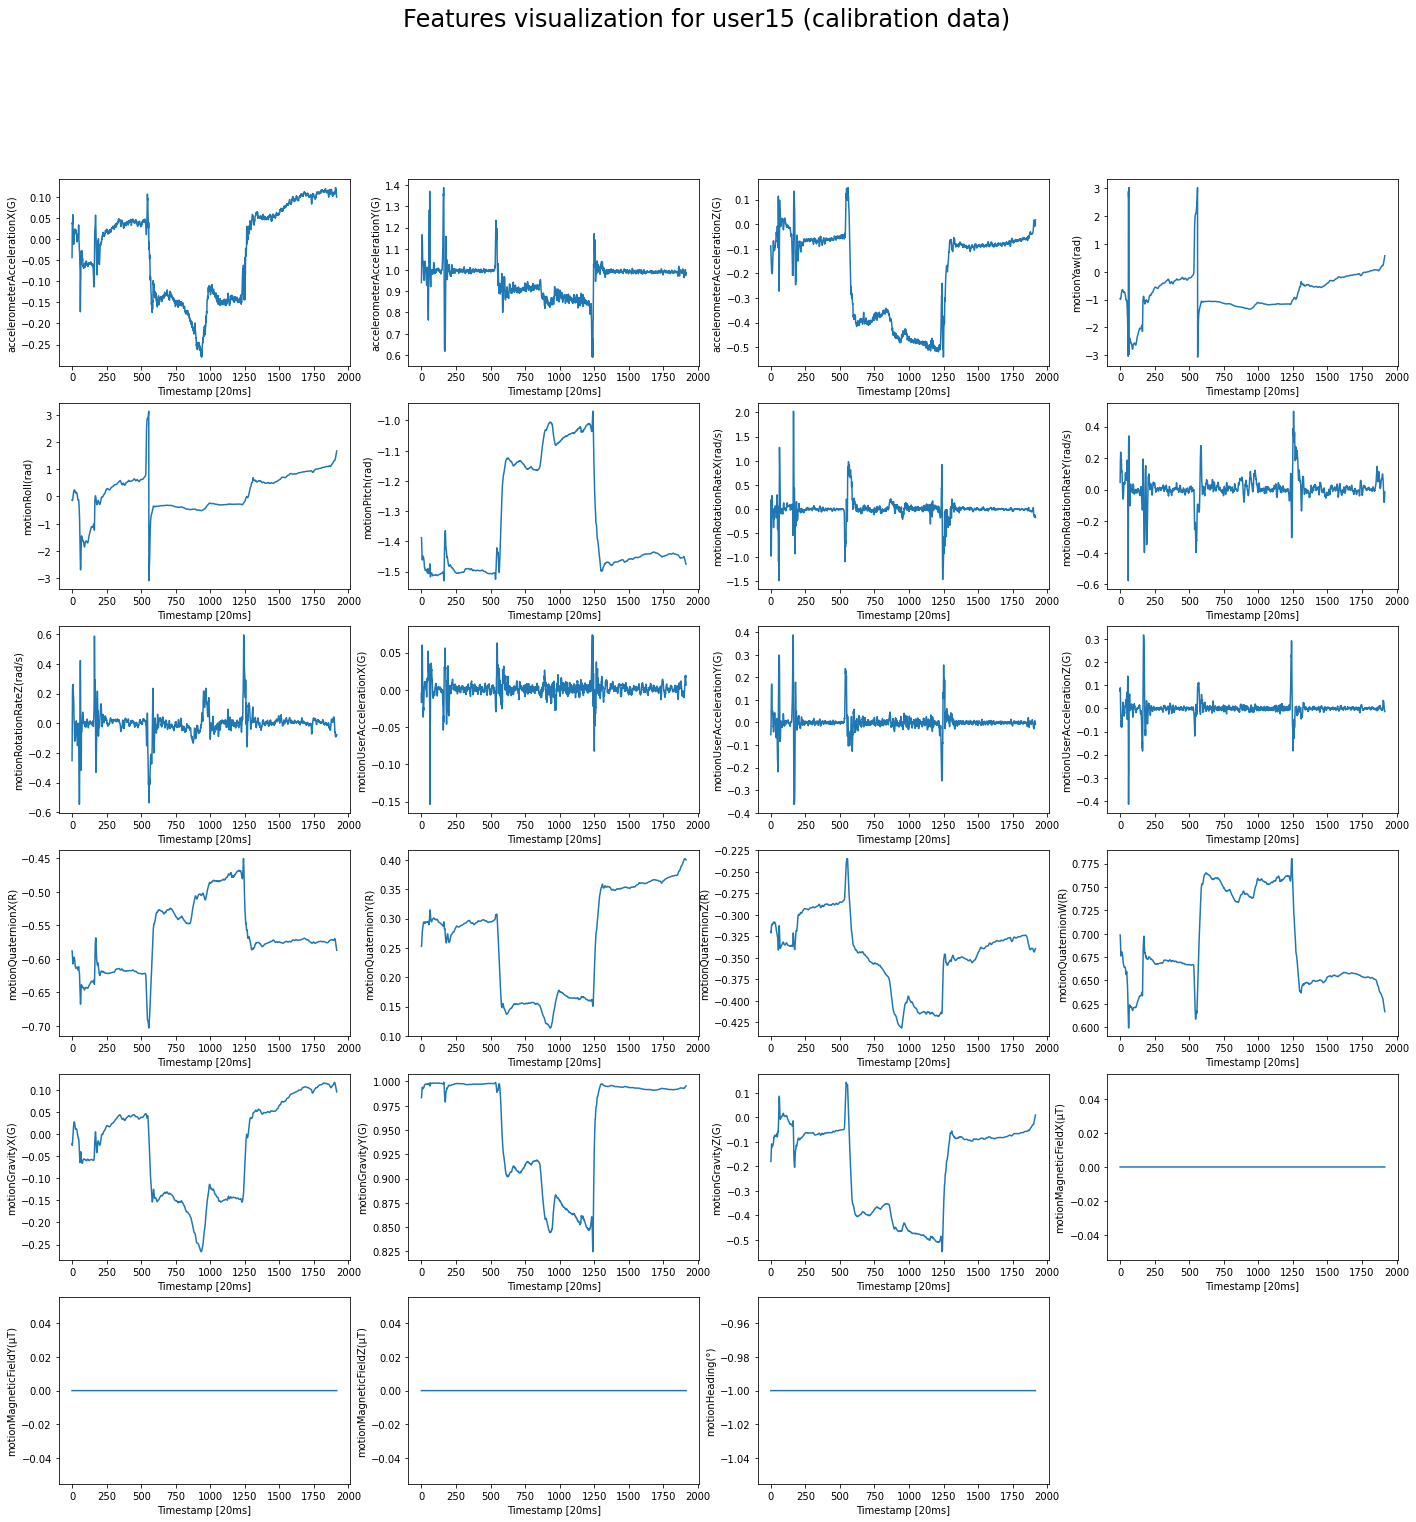

In [ ]:
# Features visualization for user 15 (common to all watches)
user_features = 'user15'
df_features = datas["calibration_data"][np.where(np.array(datas['user_id']) == user_features)[0].item()].copy()
to_ignore = ['epoc (ms)', 'accelerometerTimestamp_sinceReboot(s)','motionTimestamp_sinceReboot(s)','motionAttitudeReferenceFrame(txt)']
features = [x for x in df_features.columns if not x in to_ignore or to_ignore.remove(x)]

ncols, nrows = 4,math.ceil(len(features)/4)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows,figsize=(24,24))
fig.suptitle('Features visualization for {} (calibration data)'.format(user_features), fontsize=24)
for i, col in enumerate(features):
    axes[i//ncols][i%ncols].plot(df_features[features][col].values, label = col)
    #axes[i//ncols][i%ncols].legend()
    axes[i//ncols][i%ncols].set_xlabel('Timestamp [20ms]')
    axes[i//ncols][i%ncols].set_ylabel(col)

axes.flat[-1].set_visible(False)
plt.show()

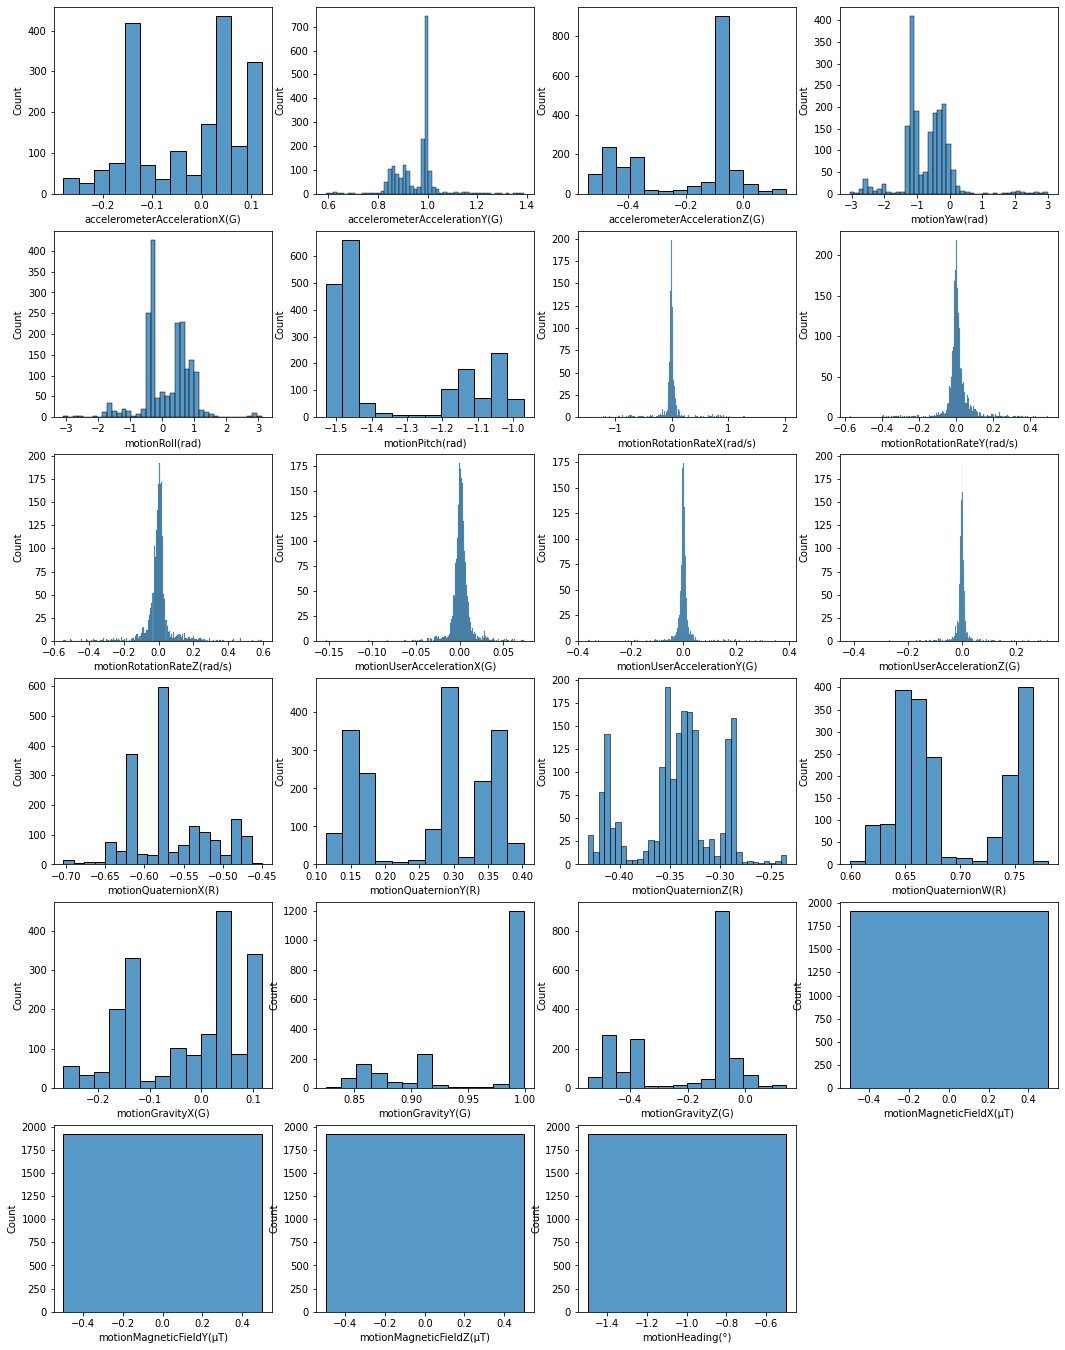

In [ ]:
# Distribution of features
ncols, nrows = 4,math.ceil(len(features)/4)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows,figsize=(18,24))
for i, col in enumerate(features):
    sns.histplot(df_features[features][col], ax=axes[i//ncols][i%ncols])
axes.flat[-1].set_visible(False)
plt.show()

### Calibration signals

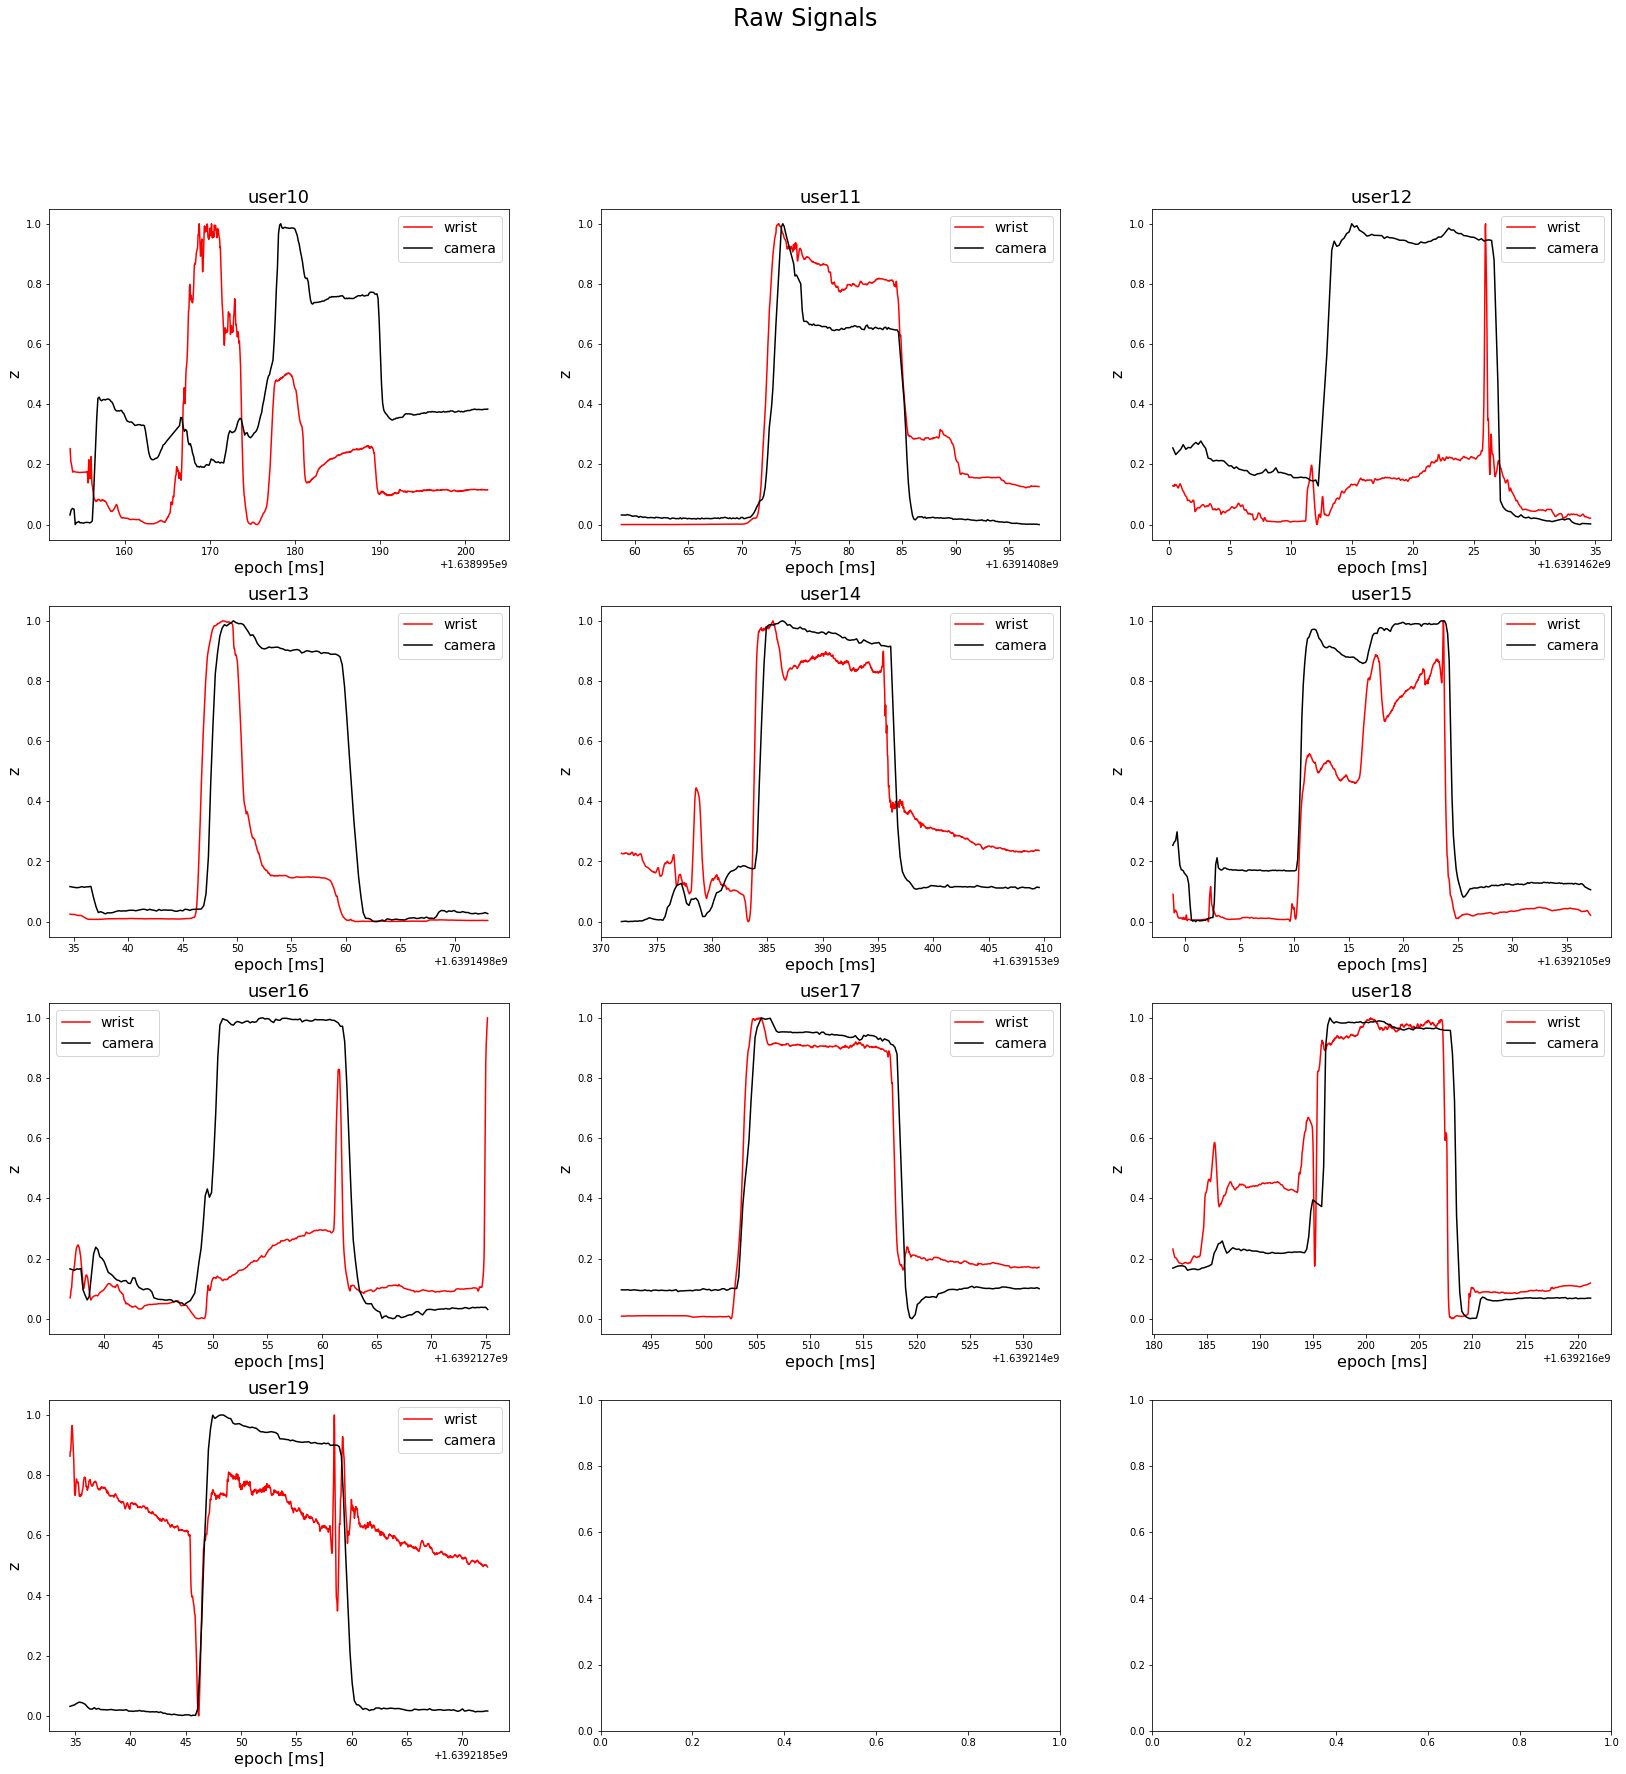

In [ ]:
# Calibration signals: Here the plots are generated with respect to the motionGravity norm vector
# as it is the less noisy signal that best represents the calibration motion
users = unique_user_ids[:12]
n_users = len(users)+1
ncols, nrows = 3, math.ceil(n_users/3)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows,figsize=(28,7*nrows))
fig.suptitle('Raw Signals', fontsize=24)
for i, user in enumerate(users):
  calibration_data = datas["calibration_data"][i]
  calibration_cam = datas["calibration_cam"][i]
  # Extract and normalize camera
  Y_cam = calibration_cam['wrist_y_data']
  Y_cam = (Y_cam - Y_cam.min(axis=0)) / (Y_cam.max(axis=0) - Y_cam.min(axis=0))
  t_cam = calibration_cam['time']
  # Extract and normalize wrsit data
  Y_wrist = -1*calibration_data['motionGravityY(G)']
  Y_wrist = -1*np.sqrt(calibration_data['motionGravityY(G)'].values**2 +calibration_data['motionGravityY(G)'].values**2 + calibration_data['motionGravityY(G)'].values**2)
  Y_wrist = (Y_wrist - Y_wrist.min(axis=0)) / (Y_wrist.max(axis=0) - Y_wrist.min(axis=0))
  t_wrist = calibration_data['epoc (ms)']
  # Append plot to axis
  axes[i//3,i%3].plot(t_wrist, Y_wrist, color='red', label='wrist')
  axes[i//3,i%3].plot(t_cam, Y_cam, color='black', label='camera')
  axes[i//3,i%3].set_title('{}'.format(user), fontsize=18)
  axes[i//3,i%3].set_xlabel('epoch [ms]', fontsize=16)
  axes[i//3,i%3].set_ylabel('z', fontsize=16)
  axes[i//3,i%3].legend(fontsize=14)

### Sequences creation

In [ ]:
data = None
data_temp = None
series_id = 0
for user_id in tqdm(unique_user_ids):
    data_temp = datas["data"][np.where(np.array(datas['user_id']) == user_id)[0].item()]
    data_temp['label'] = ['no_label' for i in range(len(data_temp))]
    data_temp['series_id'] = np.nan
    records_data = records[records['start_time']>=np.array(data_temp['epoc (ms)'])[0]][records['end_time'] <= np.array(data_temp['epoc (ms)'])[-1]]
    for i in range(len(records_data)):
      #print((records_data["class"].iloc[i]))
      indexes = np.intersect1d(np.where(np.array(data_temp['epoc (ms)']>=records_data['start_time'].iloc[i]))[0], np.where(np.array(data_temp['epoc (ms)']<=records_data['end_time'].iloc[i]).tolist()))
      data_temp['label'].iloc[indexes] = records_data.iloc[i]["class"]
      series_id +=1
      data_temp['series_id'].iloc[indexes] = series_id
    if data is None:
      data = data_temp
    else:
      data = data.append(data_temp)

In [ ]:
# Save labeled data to .csv file
#data.to_csv(base_folder+'Data/labeled_data_apple.csv', index=False)

## MMS+ Data

### Read seperate data file for each user

In [ ]:
# Create a map between user_id, data type and the corresponding file
data_folder = base_folder + 'Data/MMS+/'
df = pd.DataFrame(columns=['filename', 'user_id', 'data_type'])
for i, data_file in enumerate(os.listdir(data_folder)):
  user_id = data_file.partition('_')[0]
  partition2 = data_file.partition('_')[2]
  data_type = partition2.partition('.')[0]
  df = df.append({'filename':data_file, 'user_id': user_id, 'data_type': data_type}, ignore_index=True)
df.head()

,filename,user_id,data_type
0,user14_Magnetometer.csv,user14,Magnetometer
1,user14_Gyroscope.csv,user14,Gyroscope
2,user14_Accelerometer.csv,user14,Accelerometer
3,user15_Accelerometer.csv,user15,Accelerometer
4,user15_Gyroscope.csv,user15,Gyroscope


In [ ]:
# Merge data from different files

if not os.path.exists(base_folder+'Data/Cleaned_Data/'):
  os.makedirs(base_folder+'Data/Cleaned_Data/')

features = ['x-axis (T)', 'y-axis (T)', 'z-axis (T)',
            'x-axis (deg/s)', 'y-axis (deg/s)', 'z-axis (deg/s)',
            'x-axis (g)', 'y-axis (g)', 'z-axis (g)']
            
# Merge data from different files according to each user
unique_user_ids = df['user_id'].unique()
for user_id in tqdm(unique_user_ids):
  if len(user_id)>6: # Find solution for user14p2 
    continue
  df_user = df[df['user_id']==user_id].sort_values(by='data_type').reset_index()
  if len(df_user)>3: # Only interested in users with magnetometer data
    continue

  data0 = pd.read_csv(data_folder + df_user['filename'][0])
  data1 = pd.read_csv(data_folder + df_user['filename'][1])
  data2 = pd.read_csv(data_folder + df_user['filename'][2])
  if data0.columns[0] == 'epoch (ms)':
    data0.rename(columns = {'epoch (ms)':'epoc (ms)'}, inplace = True)
    data1.rename(columns = {'epoch (ms)':'epoc (ms)'}, inplace = True)
    data2.rename(columns = {'epoch (ms)':'epoc (ms)'}, inplace = True)
  data0 = data0.sort_values(by=['epoc (ms)'])
  data1 = data1.sort_values(by=['epoc (ms)'])
  data2 = data2.sort_values(by=['epoc (ms)'])

  user_data = pd.merge_asof(data0, data1, on ='epoc (ms)', tolerance=40,  direction = 'nearest').dropna()
  user_data = pd.merge_asof(user_data, data2, on ='epoc (ms)', tolerance=40,  direction = 'nearest').dropna()
  user_data = user_data.dropna()
  user_data.to_csv(base_folder+'Data/Cleaned_Data/{}.csv'.format(user_id))

100%|██████████| 29/29 [02:54<00:00,  6.01s/it]


In [ ]:
# Read cleaned datafiles for each user and append them into one dictionary 
datas = {"user_id":[],"data":[],"calibration_data":[], "calibration_cam":[], "time_shift":[], "records_data":[]};
unique_user_ids = []
for i, filename in enumerate(os.listdir(base_folder+'Data/Cleaned_Data')):
  if filename[:4] == 'user':
    unique_user_ids.append(filename[:6])

for user_id in tqdm(unique_user_ids):
  data = pd.read_csv(base_folder+'Data/Cleaned_Data/{}.csv'.format(user_id))
  path_to_calibration = calibration_datafoler+'/calibration{}.csv'.format(user_id[4:])
  calibration_cam = pd.read_csv(path_to_calibration)
  calibration_cam['time'] = calibration_cam['time']*1000
  calibration_data = data[calibration_cam['time'][0]<data['epoc (ms)']][data['epoc (ms)'] <= np.array(calibration_cam['time'])[-1]]
  datas["user_id"].append(user_id)
  datas["data"].append(data)
  datas["calibration_data"].append(calibration_data)
  datas["calibration_cam"].append(calibration_cam)

### Features visualization and basic statistics

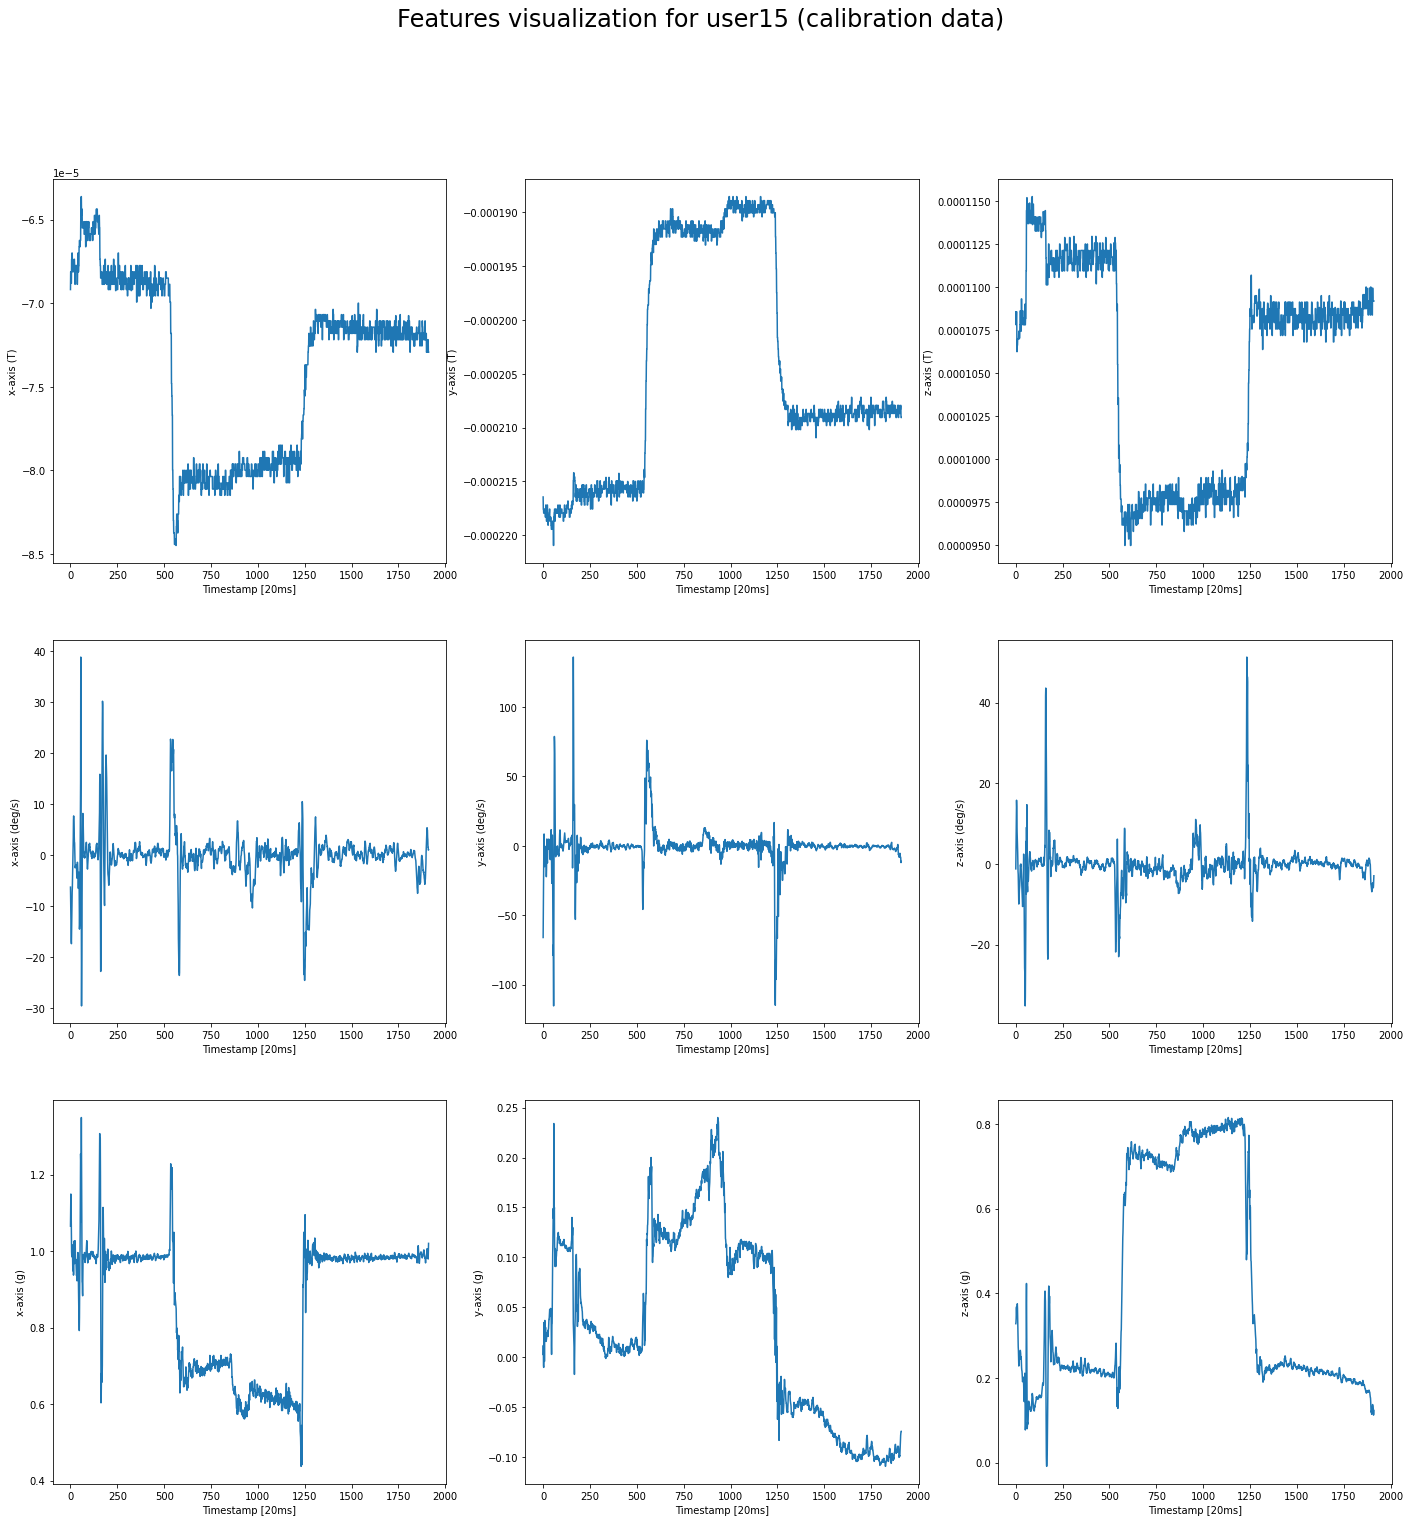

In [ ]:
# Features visualization for user 15 (common to all watches)
user_features = 'user15'
df_features = datas["calibration_data"][np.where(np.array(datas['user_id']) == user_features)[0].item()].copy()
features = ['x-axis (T)', 'y-axis (T)', 'z-axis (T)',
            'x-axis (deg/s)', 'y-axis (deg/s)', 'z-axis (deg/s)',
            'x-axis (g)', 'y-axis (g)', 'z-axis (g)']

ncols, nrows = 3,math.ceil(len(features)/4)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows,figsize=(24,24))
fig.suptitle('Features visualization for {} (calibration data)'.format(user_features), fontsize=24)
for i, col in enumerate(features):
    axes[i//ncols][i%ncols].plot(df_features[features][col].values, label = col)
    #axes[i//ncols][i%ncols].legend()
    axes[i//ncols][i%ncols].set_xlabel('Timestamp [20ms]')
    axes[i//ncols][i%ncols].set_ylabel(col)

plt.show()

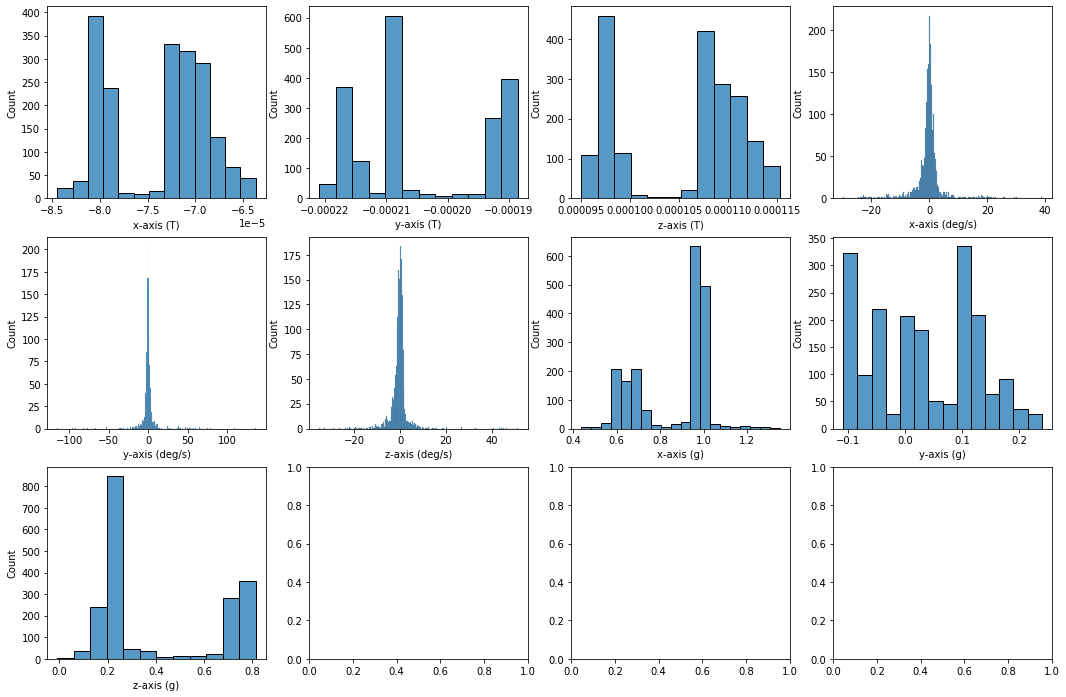

In [ ]:
# Distribution of features
ncols, nrows = 4,math.ceil(len(features)/4)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows,figsize=(18,12))
for i, col in enumerate(features):
    sns.histplot(df_features[features][col], ax=axes[i//ncols][i%ncols])
plt.show()

### Calibration signals

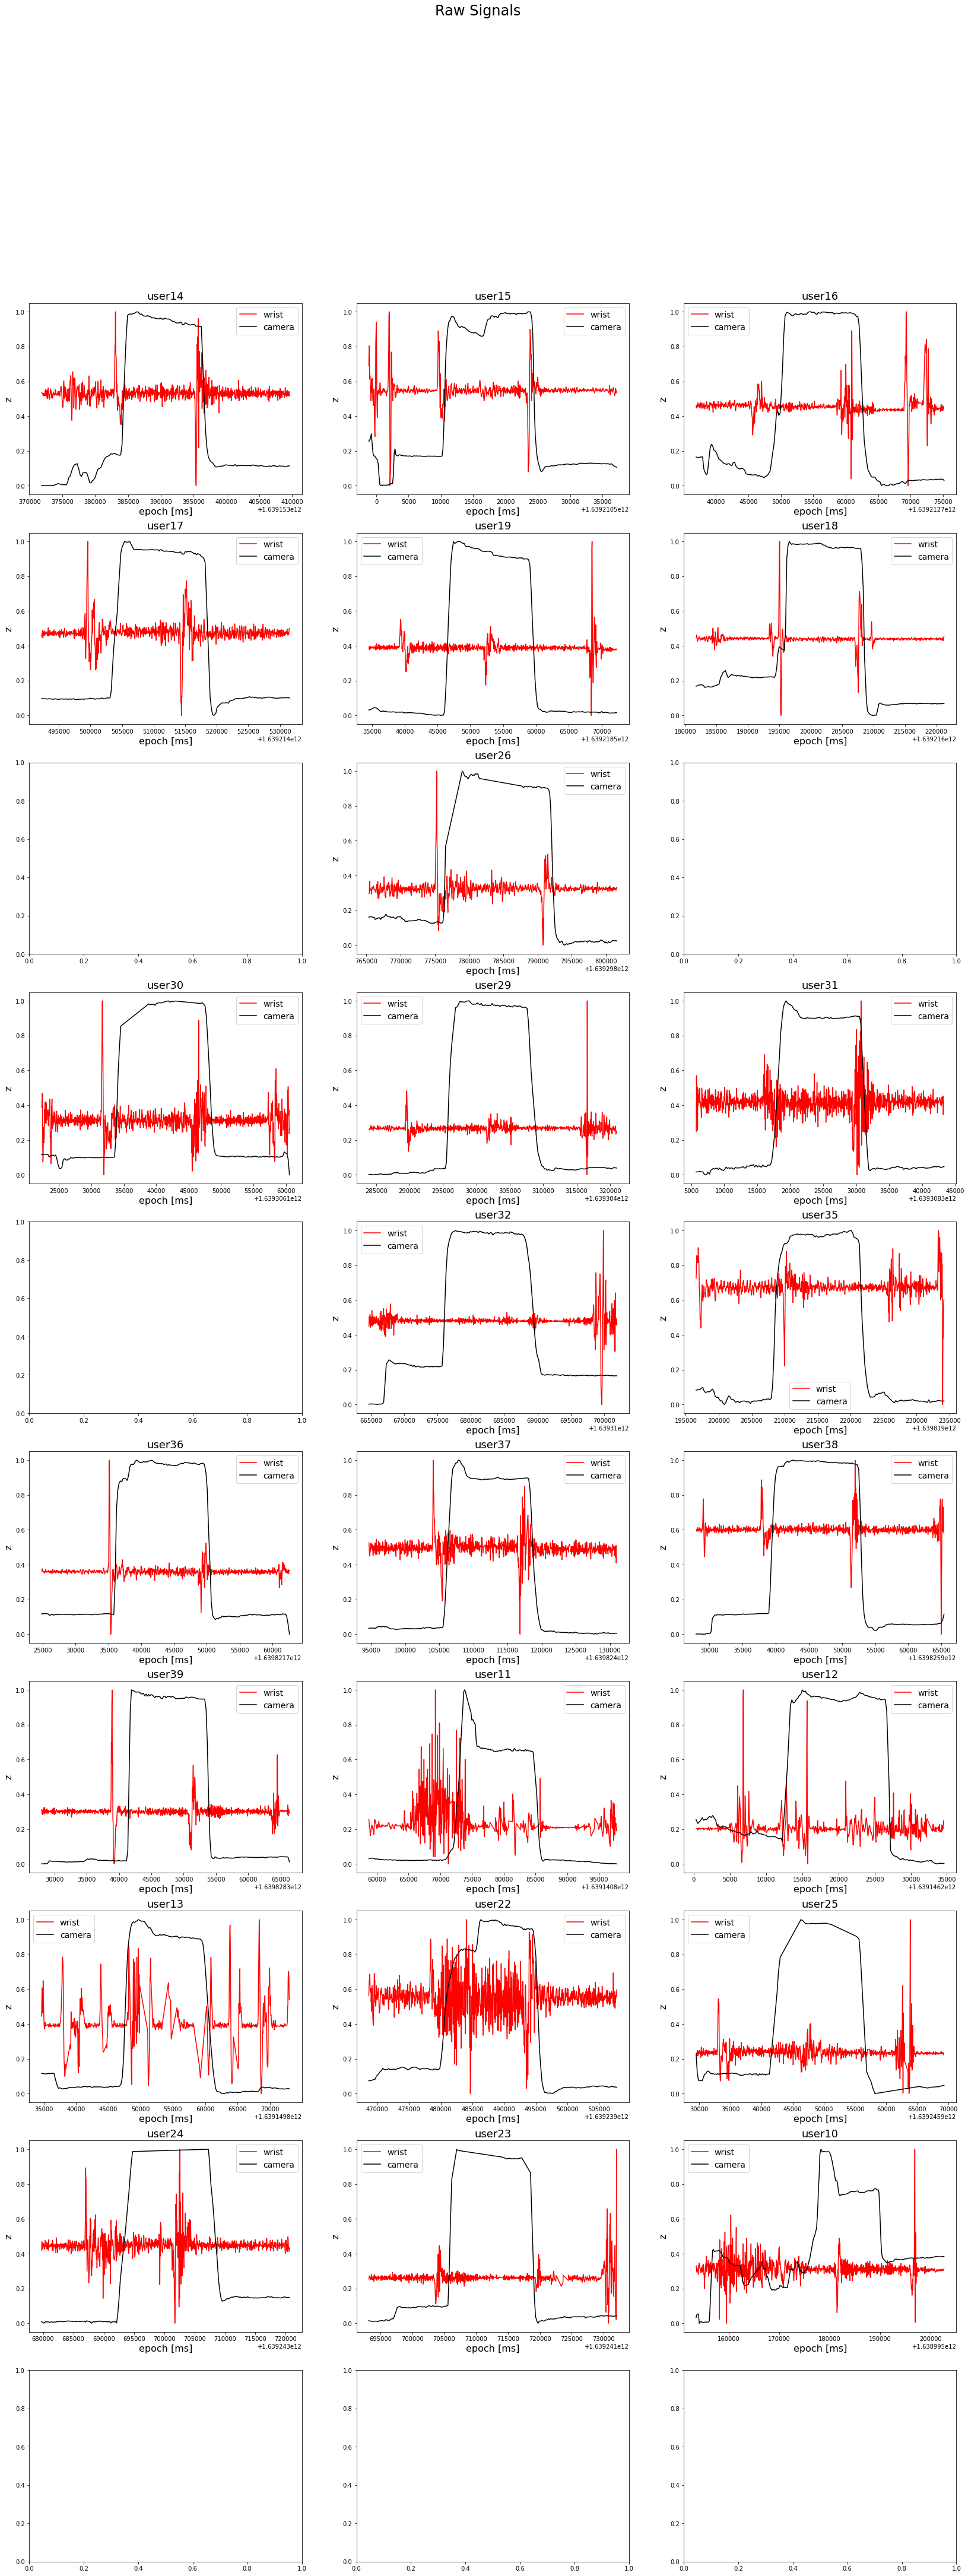

In [ ]:
# Calibration signals: Here the plots are generated with respect to the motionGravity norm vector
# as it is the less noisy signal that best represents the calibration motion
users = unique_user_ids
n_users = len(users)+1
ncols, nrows = 3, math.ceil(n_users/3)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows,figsize=(28,7*nrows))
fig.suptitle('Raw Signals', fontsize=24)
for i, user in enumerate(users):
  calibration_data = datas["calibration_data"][i]
  if len(calibration_data)==0:
    continue
  calibration_cam = datas["calibration_cam"][i]
  # Extract and normalize camera
  Y_cam = calibration_cam['wrist_y_data']
  Y_cam = (Y_cam - Y_cam.min(axis=0)) / (Y_cam.max(axis=0) - Y_cam.min(axis=0))
  t_cam = calibration_cam['time']
  # Extract and normalize wrsit data
  Y_wrist = np.sqrt(calibration_data['x-axis (g)'].values**2 +calibration_data['y-axis (g)'].values**2 + calibration_data['z-axis (g)'].values**2)
  Y_wrist = (Y_wrist - Y_wrist.min(axis=0)) / (Y_wrist.max(axis=0) - Y_wrist.min(axis=0))
  t_wrist = calibration_data['epoc (ms)']
  # Append plot to axis
  axes[i//3,i%3].plot(t_wrist, Y_wrist, color='red', label='wrist')
  axes[i//3,i%3].plot(t_cam, Y_cam, color='black', label='camera')
  axes[i//3,i%3].set_title('{}'.format(user), fontsize=18)
  axes[i//3,i%3].set_xlabel('epoch [ms]', fontsize=16)
  axes[i//3,i%3].set_ylabel('z', fontsize=16)
  axes[i//3,i%3].legend(fontsize=14)

### Sequences creation

In [ ]:
# Convert time from (s) to (ms)
records['start_time'] = records['start_time']*1000
records['end_time'] = records['end_time']*1000

# We select a subset of synchronized data : 'user14', 'user15', 'user18' have synchronized data
from datetime import datetime
import time 
import math
def convert(epoc):
  return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(epoc/1000))
test = 0
data = None
data_temp = None
series_id = 0
users_with_problems = []
for i, user_id in enumerate(['user14', 'user15', 'user18']):
    data_temp = datas["data"][np.where(np.array(datas['user_id']) == user_id)[0].item()].copy()
    data_temp['label'] = ['no_label' for i in range(len(data_temp))]
    data_temp['series_id'] = np.nan
    
    records_data = records.iloc[np.where(np.array(records['user_id']== int(user_id[4:])))]
    '''
    if (records_data['end_time'][-1:].values.item() > data_temp['epoc (ms)'][-1:].values.item()) or (records_data['start_time'].iloc[0] <data_temp['epoc (ms)'].iloc[0]):
      users_with_problems.append(user_id)
    '''
    for i in range(len(records_data)):
      indexes =  np.intersect1d(np.where(np.array(data_temp['epoc (ms)']>=records_data['start_time'].iloc[i]))[0], np.where(np.array(data_temp['epoc (ms)']<=records_data['end_time'].iloc[i]).tolist()))
      data_temp['label'].iloc[indexes] = records_data.iloc[i]["class"]
      series_id +=1
      data_temp['series_id'].iloc[indexes] = series_id
    if len(data_temp.label.unique())<8:
      print('warning!!')
    if data is None:
      data = data_temp
    else:
      data = data.append(data_temp)

In [ ]:
# Save labeled data to .csv file
#data.to_csv(base_folder+'Data/labeled_data_mms.csv', index=False)

## AX3 Data

### Read seperate data file for each user

In [ ]:
data_folder = base_folder + 'Data/AX3/'
df = pd.DataFrame(columns=['user_id', 'filename'])
for i, data_file in enumerate(os.listdir(data_folder)):
  part = data_file
  while True:
    part = part.partition('user')[2]
    if len(part)!=0:
      df = df.append({'filename':data_file, 'user_id': 'user{}'.format(part[:2])}, ignore_index=True)
    else:
      break
df.head()

,user_id,filename
0,user10,user10.csv
1,user15,user15.csv
2,user16,user16.csv
3,user17,user17.csv
4,user18,user18.csv


In [ ]:
# Save all user's relative datas in one dictionary
datas = {"user_id":[],"data":[],"calibration_data":[], "calibration_cam":[], "time_shift":[], "records_data":[]};
unique_user_ids = df['user_id'].unique()
for user_id in unique_user_ids:
  data =pd.read_csv(data_folder+df['filename'][df['user_id']==user_id].item(), index_col=0)
  data.reset_index(inplace=True)
  data.columns = ['epoc (ms)', 'acc_x', 'acc_y', 'acc_z']
  data['epoc (ms)'] = data['epoc (ms)']*1000

  path_to_calibration = calibration_datafoler+'/calibration{}.csv'.format(user_id[4:])
  calibration_cam = pd.read_csv(path_to_calibration)
  calibration_cam['time'] = calibration_cam['time']*1000
  calibration_data = data[calibration_cam['time'][0]<data['epoc (ms)']][data['epoc (ms)'] <= np.array(calibration_cam['time'])[-1]]
  if len(calibration_data)==0:
    print(user_id)
    calibration_data = data[calibration_cam['time'][0]+ 1*3600000<data['epoc (ms)']][data['epoc (ms)'] <= np.array(calibration_cam['time'])[-1]+ 1*3600000]
    
  datas["user_id"].append(user_id)
  datas["data"].append(data)
  datas["calibration_data"].append(calibration_data)
  datas["calibration_cam"].append(calibration_cam)

### Features visualization and basic statistics

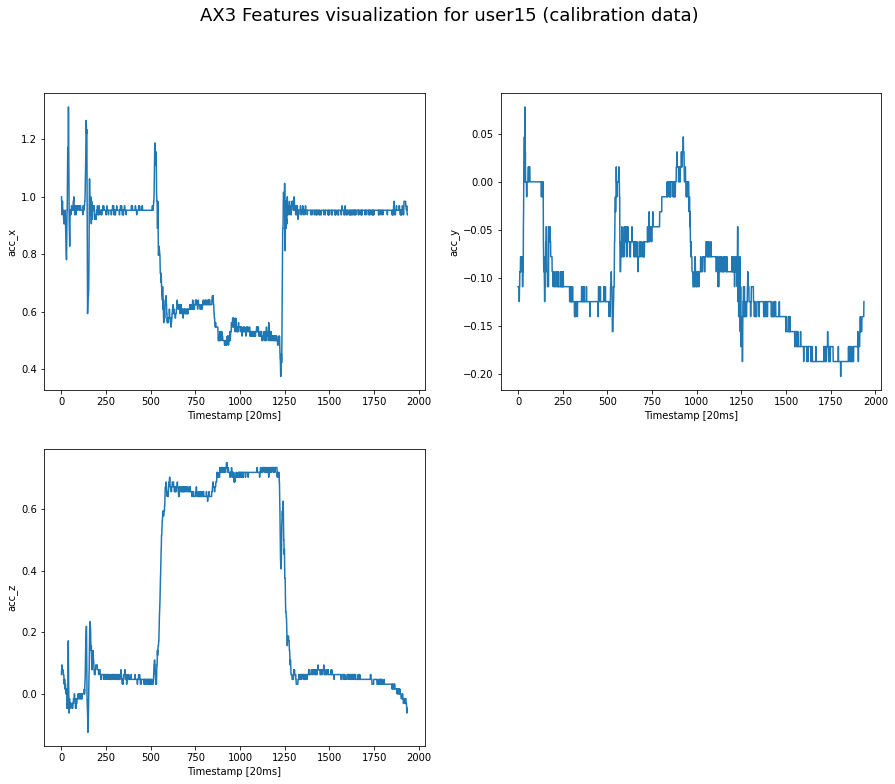

In [ ]:
# Features visualization for user 15 (common to all watches)
user_features = 'user15'
df_features = datas["calibration_data"][np.where(np.array(datas['user_id']) == user_features)[0].item()].copy()
to_ignore = ['epoc (ms)']
features = [x for x in df_features.columns if not x in to_ignore or to_ignore.remove(x)]

ncols, nrows = 2,2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows,figsize=(15,12))
fig.suptitle('AX3 Features visualization for {} (calibration data)'.format(user_features), fontsize=18)
for i, col in enumerate(features):
    axes[i//ncols][i%ncols].plot(df_features[features][col].values, label = col)
    #axes[i//ncols][i%ncols].legend()
    axes[i//ncols][i%ncols].set_xlabel('Timestamp [20ms]')
    axes[i//ncols][i%ncols].set_ylabel(col)

axes.flat[-1].set_visible(False)
plt.show()

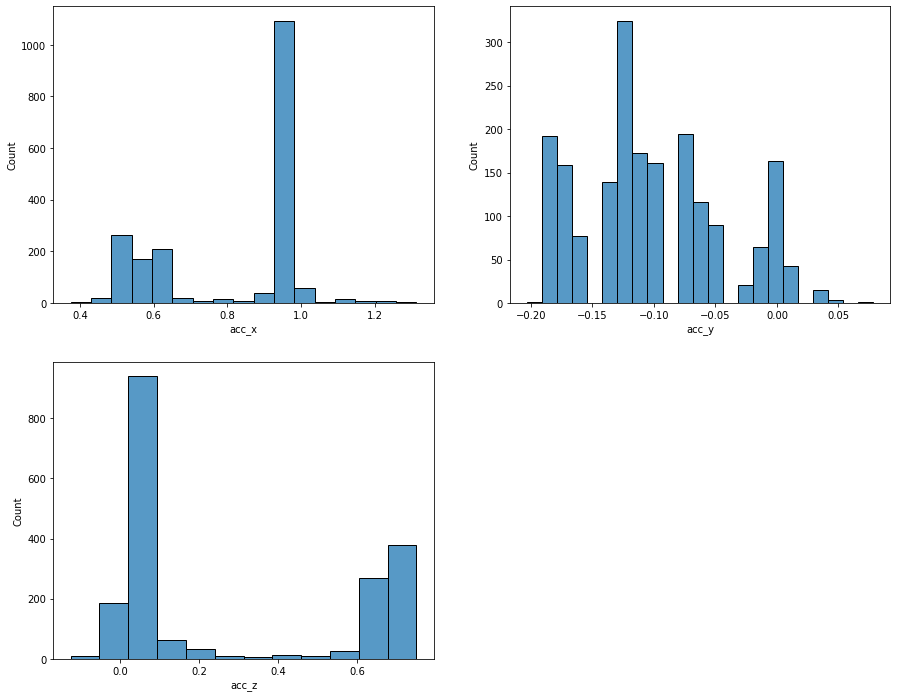

In [ ]:
# Distribution of features
ncols, nrows = 2,2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows,figsize=(15,12))
for i, col in enumerate(features):
    sns.histplot(df_features[features][col], ax=axes[i//ncols][i%ncols])
axes.flat[-1].set_visible(False)
plt.show()

### Calibration signals

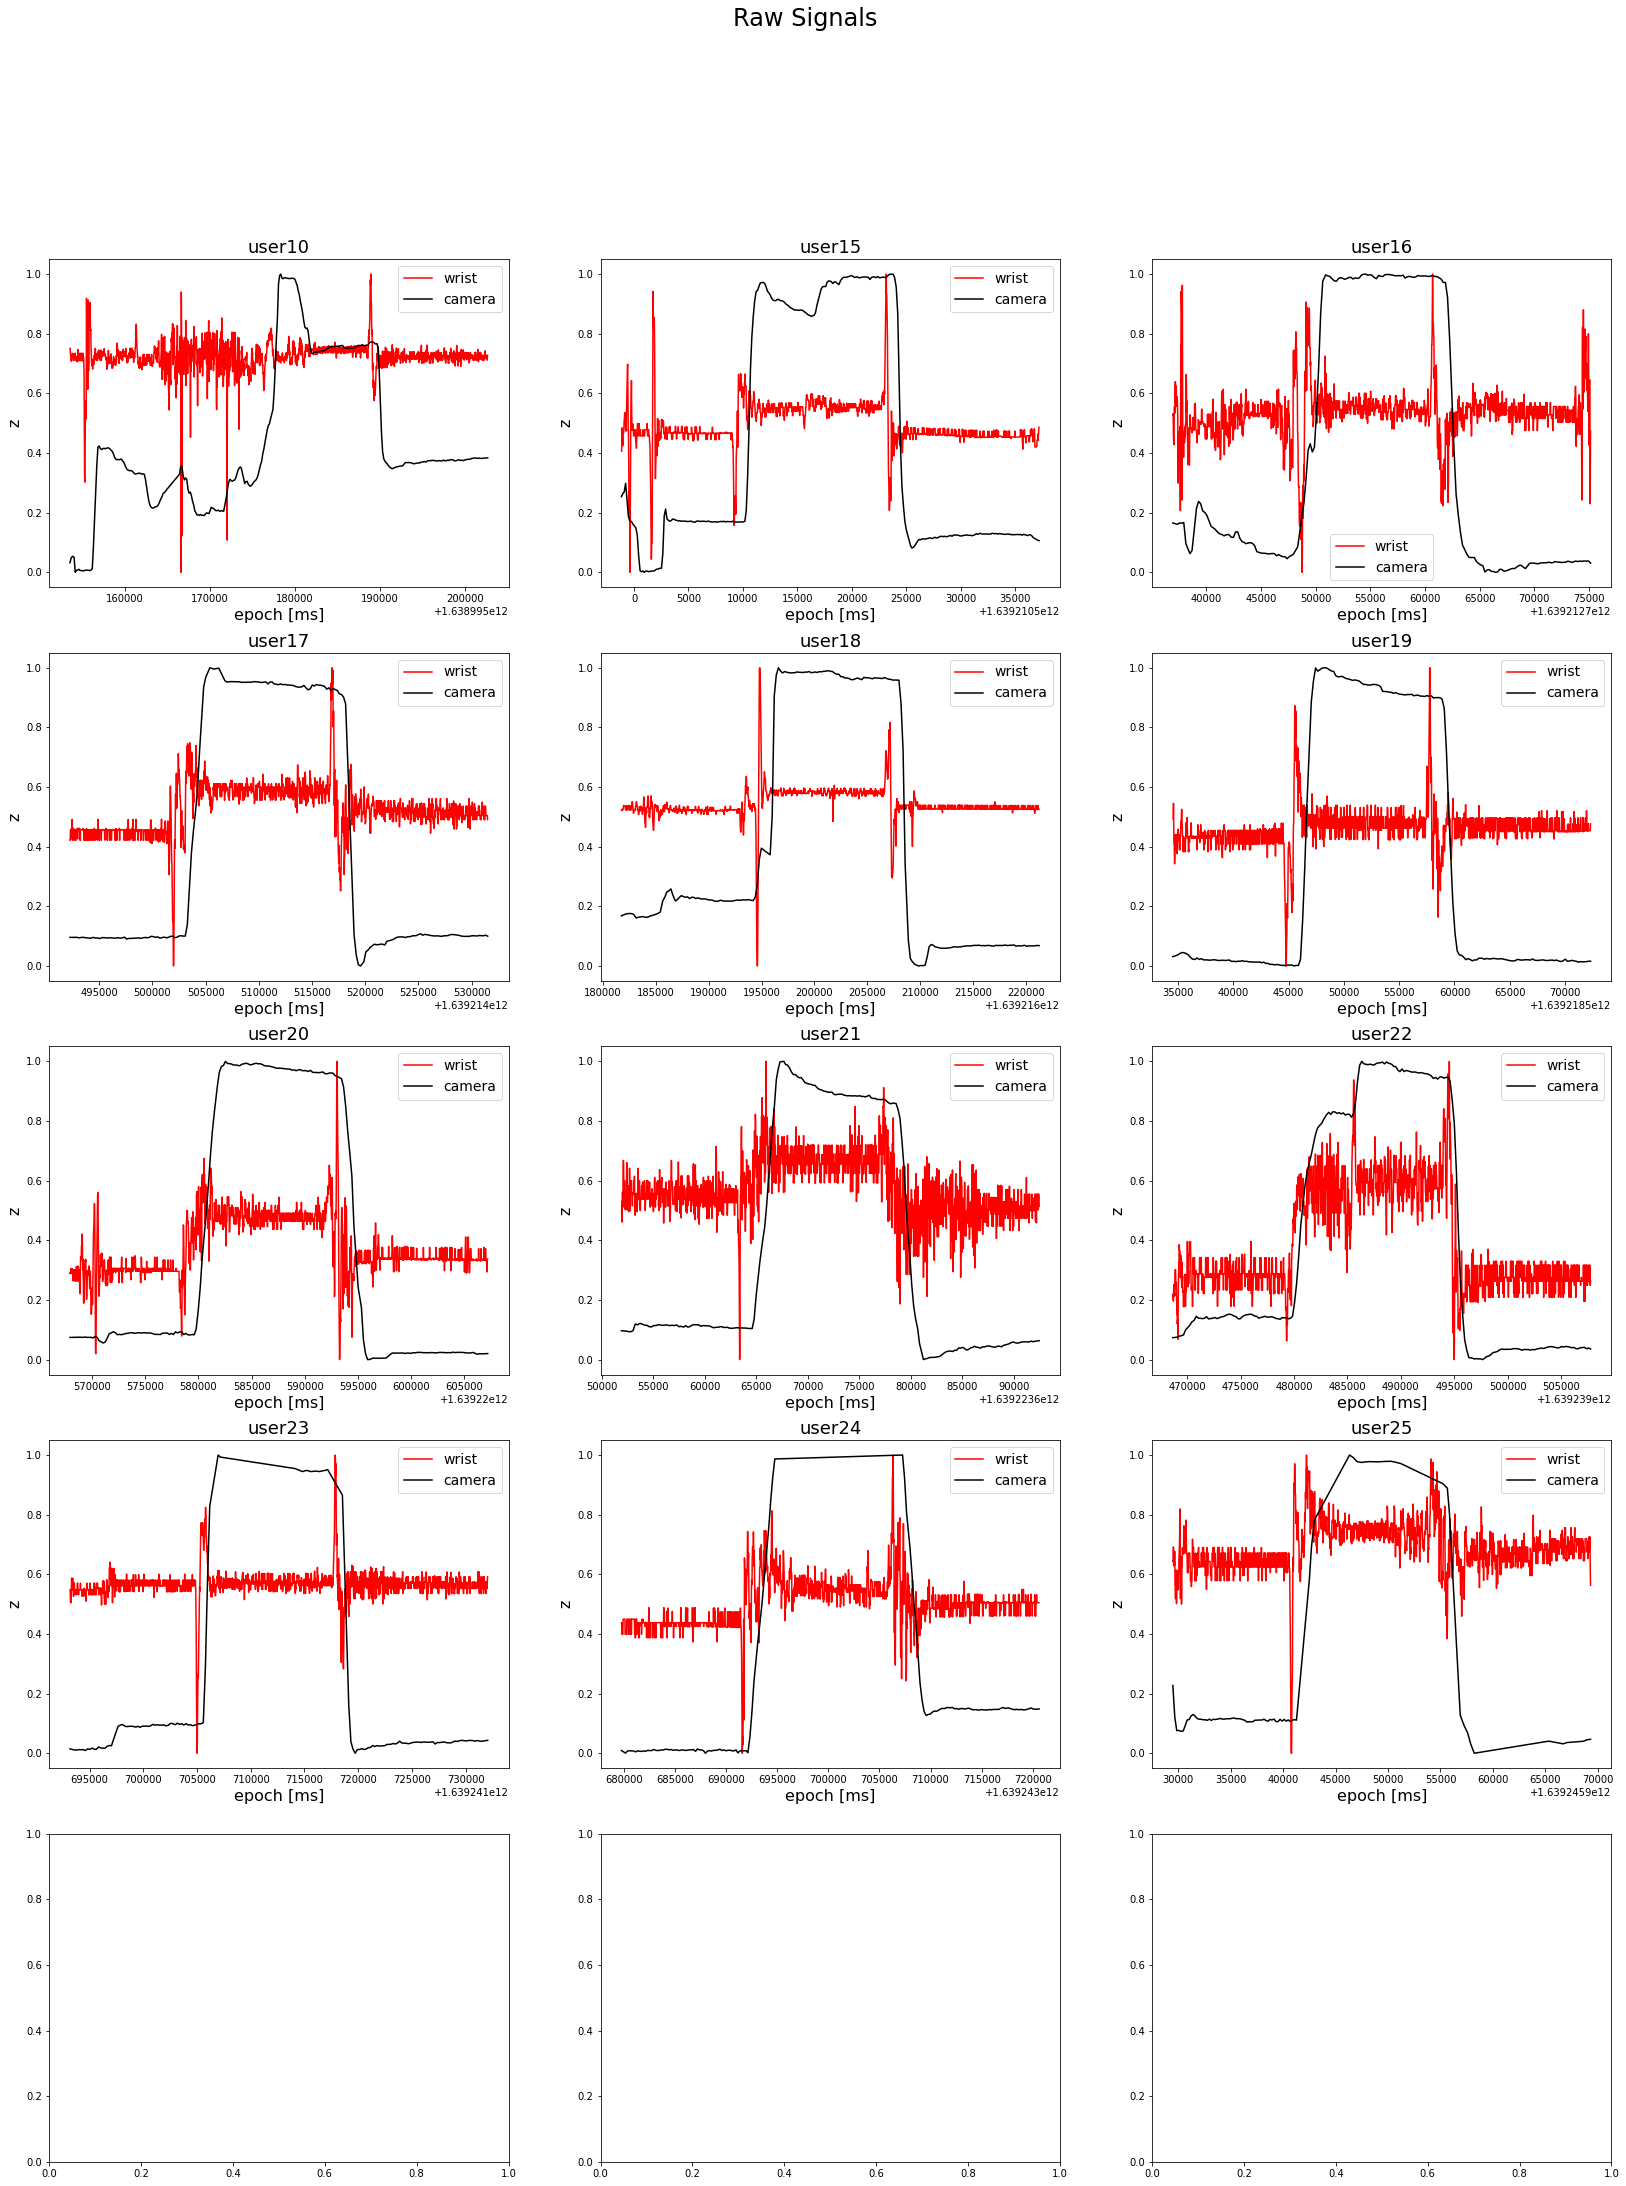

In [ ]:
# Calibration signals: Here the plots are generated with respect to the motionGravity norm vector
# as it is the less noisy signal that best represents the calibration motion
users = unique_user_ids[:12]
n_users = len(users)+1
ncols, nrows = 3, math.ceil(n_users/3)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows,figsize=(28,7*nrows))
fig.suptitle('Raw Signals', fontsize=24)
for i, user in enumerate(users):
  calibration_data = datas["calibration_data"][i]
  calibration_cam = datas["calibration_cam"][i]
  # Extract and normalize camera
  Y_cam = calibration_cam['wrist_y_data']
  Y_cam = (Y_cam - Y_cam.min(axis=0)) / (Y_cam.max(axis=0) - Y_cam.min(axis=0))
  t_cam = calibration_cam['time']
  # Extract and normalize wrsit data
  Y_wrist = -1*np.sqrt(calibration_data['acc_x'].values**2 +calibration_data['acc_y'].values**2 + calibration_data['acc_z'].values**2)
  Y_wrist = (Y_wrist - Y_wrist.min(axis=0)) / (Y_wrist.max(axis=0) - Y_wrist.min(axis=0))
  t_wrist = calibration_data['epoc (ms)']-3600000 # shift by 3600000 due to the winter hour
  # Append plot to axis
  axes[i//3,i%3].plot(t_wrist, Y_wrist, color='red', label='wrist')
  axes[i//3,i%3].plot(t_cam, Y_cam, color='black', label='camera')
  axes[i//3,i%3].set_title('{}'.format(user), fontsize=18)
  axes[i//3,i%3].set_xlabel('epoch [ms]', fontsize=16)
  axes[i//3,i%3].set_ylabel('z', fontsize=16)
  axes[i//3,i%3].legend(fontsize=14)

### Sequences creation

In [ ]:
from datetime import datetime
import time 
import math
def convert(epoc):
  return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(epoc/1000))

features = ['acc_x','acc_y','acc_z']
test = 0
data = None
data_temp = None
series_id = 0

for i, user_id in enumerate(unique_user_ids):
    data_temp = datas["data"][np.where(np.array(datas['user_id']) == user_id)[0].item()].copy()

    data_temp['label'] = ['no_label' for i in range(len(data_temp))]
    data_temp['series_id'] = np.nan
    records_data = records.iloc[np.where(np.array(records['user_id']== int(user_id[4:])))]
    time_ref = (datetime.strptime(records_data['date_time'].iloc[0][4:], '%b %d %H:%M:%S %Y') - datetime(1970,1,1)).total_seconds()*1000
    diff = time_ref- records_data['end_time'].iloc[0]
    if abs(diff)> 10000:
      data_temp['epoc (ms)'] = data_temp['epoc (ms)'] + math.copysign(3600000, -1*diff)

    for i in range(len(records_data)):
      indexes = np.intersect1d(np.where(np.array(data_temp['epoc (ms)']>=records_data['start_time'].iloc[i]))[0], np.where(np.array(data_temp['epoc (ms)']<=records_data['end_time'].iloc[i]).tolist()))
      if len(indexes)>0:
        test +=1
      data_temp['label'].iloc[indexes] = records_data.iloc[i]["class"]
      series_id +=1
      data_temp['series_id'].iloc[indexes] = series_id
    if len(data_temp.label.unique())<8:
      print('warning!!')
    if data is None:
      data = data_temp
    else:
      data = data.append(data_temp)
data[features] = (data[features]-data[features].mean())/data[features].std()

In [ ]:
# Save labeled data to .csv file
#data.to_csv(base_folder+'Data/labeled_data_ax3.csv', index=False)